In [7]:
import pandas as pd
import numpy as np
from pathlib import Path

import json
import joblib
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import datetime


# Config

In [8]:

N_ESTIMATORS = 100      
# CONTAMINATION = 'auto'  
CONTAMINATION = 0.03
RANDOM_STATE = 42
N_JOBS = -1              

SEQ_LEN = 240
PERIOD_SAMPLES = 2880


# Data loading  

In [9]:
current_dir = Path.cwd()
df = pd.read_csv(current_dir.parent / 'data' / 'train_residuals.csv')

with open(current_dir.parent / 'data' / 'metrics.json', 'r') as f:
    METRIC_NAMES = json.load(f)
    
N_FEATURES = len(METRIC_NAMES) 


# Data procession 

In [10]:
scaled_residuals_df = pd.DataFrame(index=df.index)
scaler_map ={}
for metric in METRIC_NAMES:
    scaler = StandardScaler()
    scaled_col = scaler.fit_transform(df[[metric]])
    scaled_residuals_df[metric] = scaled_col.flatten()
    scaler_map[metric] = scaler
    


In [11]:
def create_sliding_windows(data, seq_len):
    sequences = []
    for i in range(len(data) - seq_len):
        sequences.append(data[i:i+seq_len])
    return np.array(sequences)

# 3D : (Samples, TimeSteps, Features)
X_3d = create_sliding_windows(scaled_residuals_df[METRIC_NAMES].values, SEQ_LEN)
print(f"3D shape: {X_3d.shape}")

3D shape: (60235, 240, 6)


In [12]:
n_samples = X_3d.shape[0]
X_flat = X_3d.reshape(n_samples, -1)
print(f"2D Input for isolation forest: {X_flat.shape}")

2D Input for isolation forest: (60235, 1440)


# Train model

In [13]:
model = IsolationForest(
    n_estimators=N_ESTIMATORS,
    contamination=CONTAMINATION,
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS,
    verbose=0
)

In [14]:
model.fit(X_flat);

In [15]:
train_scores = model.decision_function(X_flat)

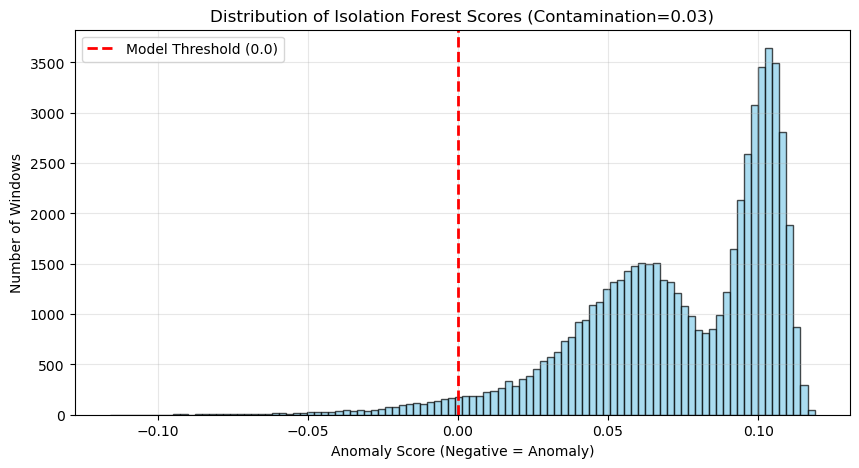

In [16]:

plt.figure(figsize=(10, 5))
plt.hist(train_scores, bins=100, color='skyblue', edgecolor='black', alpha=0.7)

plt.axvline(0, color='red', linestyle='dashed', linewidth=2, label='Model Threshold (0.0)')

plt.title(f'Distribution of Isolation Forest Scores (Contamination={CONTAMINATION})')
plt.xlabel('Anomaly Score (Negative = Anomaly)')
plt.ylabel('Number of Windows')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Savings

In [17]:
current_dir = Path.cwd()
save_dir = current_dir.parent / "models" / "isolation_forest"
save_dir.mkdir(parents=True, exist_ok=True)
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

In [18]:
model_filename = f"iforest_anomaly_detector_{timestamp}.pkl"

joblib.dump(model, save_dir / model_filename)
print(f"Model saved: {model_filename}")

Model saved: iforest_anomaly_detector_20260213_201837.pkl


In [19]:
scaler_filename = f"iforest_anomaly_scaler_map_{timestamp}.pkl"

joblib.dump(scaler_map, save_dir / scaler_filename)
print(f"Scaler map saved: {scaler_filename}")

Scaler map saved: iforest_anomaly_scaler_map_20260213_201837.pkl


In [ ]:
params_filename = f"iforest_anomaly_parameters_{timestamp}.txt"

params = {
    "MODEL_TYPE": "IsolationForest",
    "TRAIN_TIMESTAMP": timestamp,
    "METRIC_NAMES": METRIC_NAMES,
    "SEQ_LEN": SEQ_LEN,
    "N_ESTIMATORS": N_ESTIMATORS,
    "CONTAMINATION": str(CONTAMINATION), 
    "RANDOM_STATE": RANDOM_STATE,
    "INPUT_SHAPE_2D": str(X_flat.shape),
    "SCALER_TYPE": type(next(iter(scaler_map.values()))).__name__,
    "SCORE_MIN": float(train_scores.min()),
    "SCORE_MAX": float(train_scores.max())
}
with open(save_dir / params_filename, "w") as f:
    json.dump(params, f, indent=4)

print(f"params are saved {params_filename}")

params are saved iforest_anomaly_parameters_20260213_201837.txt
